## Analysis of London Homes - Energy Data 

Context
The dataset featured below was created by aggregating hourly energy consumption data from individual London homes provided by UK Power Networks. The dataset keeps track of the energy consumption of 5,567 randomly selected households in London from November 2011 to February 2014.


In [1]:
#Imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
import plotly.express as px
import plotly.graph_objects as go

import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/london-homes-energy-data/london_energy.csv


### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Read Data](#1)
- [Exploratory Data Analysis](#2)
- [Next Steps](#3)


## Read Data

In [2]:
df = pd.read_csv('/kaggle/input/london-homes-energy-data/london_energy.csv',infer_datetime_format=True)

## EDA

5 preliminary checks:
1. Sample the data using (head/tail/sample)
2. Dimensions of the data (shape)
3. Data types of the features
4. Count of missing data
5. Outliers

In [3]:
df.head()

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


<div class="alert alert-block alert-info">
<b>Features: LCLid, Date and KWH.</b> 
   
- LCLid - individual household unique identifier - (str)
- Date - date of recorded measurement - (date)
- KWH - energy consumption measurement in kWh - (float)
</div>

**Dimension of the data**

In [4]:
df.shape

(3510433, 3)

There are 3.5 million records available

**Timeframe in question**

In [5]:
print(f"The first timestamp is: {df.Date.min()} and last timestamp is : {df.Date.max()}")

The first timestamp is: 2011-11-23 and last timestamp is : 2014-02-28


**Inspect datatype for the columns**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   LCLid   object 
 1   Date    object 
 2   KWH     float64
dtypes: float64(1), object(2)
memory usage: 80.3+ MB


Date column is not in the datetime format yet. Update it and reinspect.

In [7]:
# Set the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

**Number of days in the dataset**

In [8]:
df.Date.max()-df.Date.min()

Timedelta('828 days 00:00:00')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   LCLid   object        
 1   Date    datetime64[ns]
 2   KWH     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 80.3+ MB


**Look for any missing data**

In [10]:
df.isna().sum()

LCLid    0
Date     0
KWH      0
dtype: int64

Looks like there are no empty records. 
Could there be missing days?

In [11]:
my_range = pd.date_range(start="2011-11-23", end="2014-02-28", freq='D')

print(my_range.difference(df['Date']))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


Looks like there are no missing dates in between!

In [12]:
df.describe()

,KWH
count,3.510433e+06
mean,1.013001e+01
std,9.134486e+00
min,0.000000e+00
25%,4.685000e+00
50%,7.819000e+00
75%,1.257600e+01
max,3.325560e+02


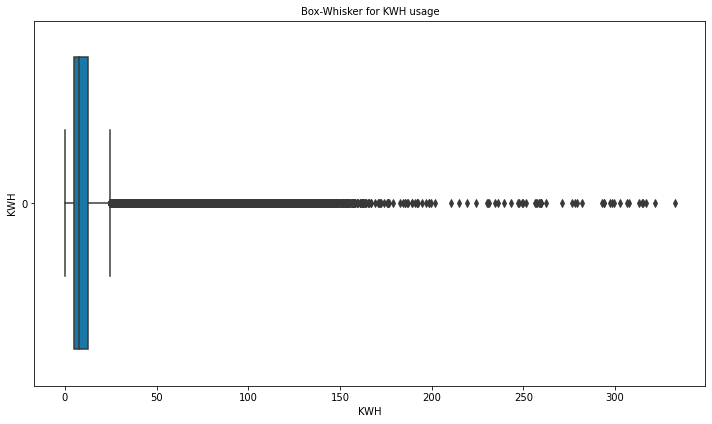

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df['KWH'],ax = ax, palette="winter",orient="h")
ax.set_title("Box-Whisker for KWH usage", fontsize = 10)
ax.set_xlabel("KWH", fontsize = 10)
ax.set_ylabel("KWH", fontsize = 10)
fig.tight_layout(pad = 1.1)
plt.show()

There are lot of outlier meters since the majority of meter usage is in the lower range.

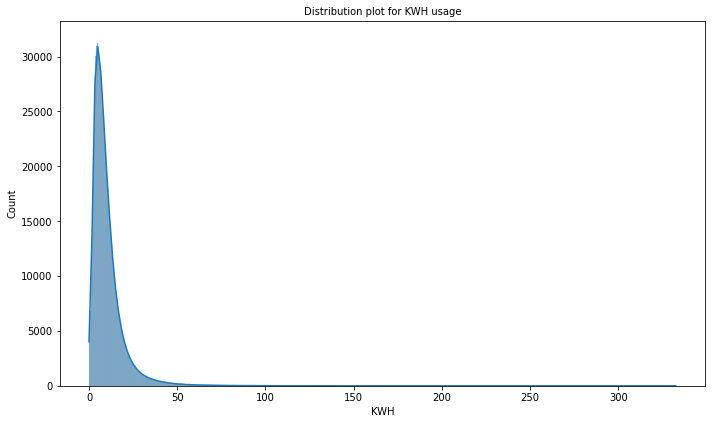

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x="KWH", kde=True)

ax.set_title("Distribution plot for KWH usage", fontsize = 10)
ax.set_xlabel("KWH", fontsize = 10)
ax.set_ylabel("Count", fontsize = 10)
fig.tight_layout(pad = 1.1)
plt.show()

**Maximum KWH Usage seen in the dataset**

In [15]:
print(f"Highest single day usage in the dataset is: {df.KWH.max()} KWH ")

Highest single day usage in the dataset is: 332.556 KWH 


Before we look at the meter which has the highest usage for a single day, let's find how many unique meters are represented in the data

In [16]:
print(f"There are {df.LCLid.nunique()} unique meters represented in the dataset ") 

There are 5566 unique meters represented in the dataset 


### Meter with the highest usage for a single day:

In [17]:
maxkwh = df['KWH'].idxmax()
print(f"Details of the meter with highest usage for a single day: \n{df.iloc[maxkwh]}")

Details of the meter with highest usage for a single day: 
LCLid              MAC002670
Date     2012-11-16 00:00:00
KWH                  332.556
Name: 1727625, dtype: object


### Visualize the usage over time for all the meters

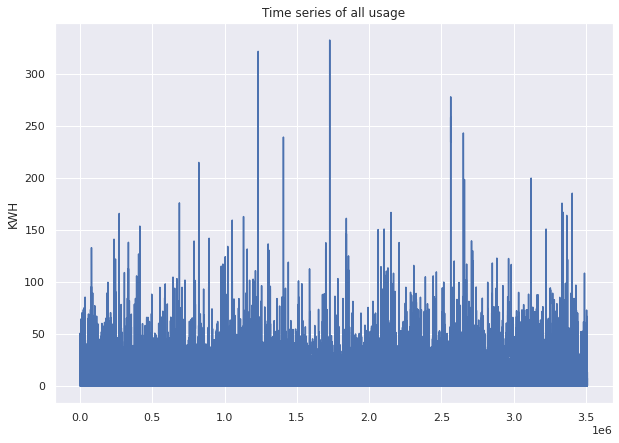

In [18]:
sns.set(rc={'figure.figsize':(10, 7)})
sns.lineplot(data=df['KWH']).set(title="Time series of all usage")
plt.show()

### Visualize the time series for the highest energy user

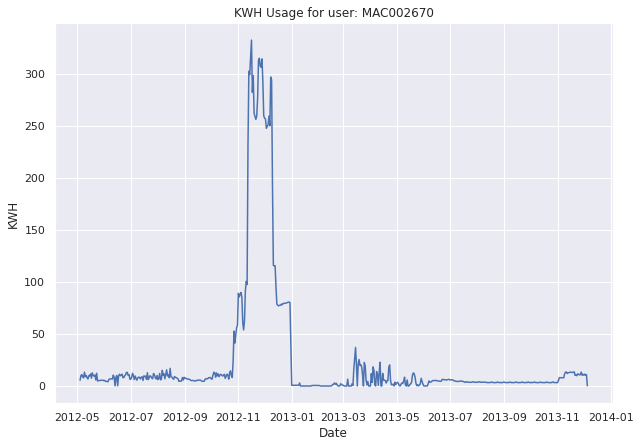

In [19]:
sns.set(rc={'figure.figsize':(10, 7)})
highUser = df[df['LCLid']=='MAC002670']

sns.lineplot(data=highUser, x='Date', y='KWH').set(title="KWH Usage for user: MAC002670")
plt.show()

Note: This meter may have a single highest usage, but it may not be the meter with most usage for the overall time period.
We can group by the meters and sum the usage to see which one it is.

In [20]:
groupedByMtr = (df
                    .groupby(["LCLid"])
                    .KWH
                    .sum()
                    .sort_values(ascending=False))

groupedByMtr[:10]

LCLid
MAC004179    65662.156
MAC005406    51990.801
MAC000557    44694.933
MAC000985    43057.082
MAC001145    42603.991
MAC004993    40790.828
MAC000105    40441.950
MAC001739    37856.631
MAC004593    37361.047
MAC003329    36358.836
Name: KWH, dtype: float64

**The Meter with the most usage is MAC004179.** Let's plot that one 

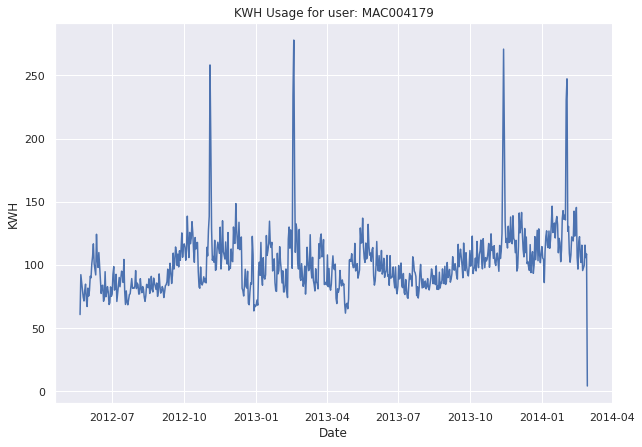

In [21]:

highestUser = df[df['LCLid']=='MAC004179']

sns.lineplot(data=highestUser, x='Date', y='KWH').set(title="KWH Usage for user: MAC004179")
plt.show()

As we can see, this meter MAC004179 has high usage throughout the period with a few occasional spikes.

In [22]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day_of_week'] = df['Date'].dt.weekday

wkdaysmap = {0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri', 5:'Sat', 6:'Sun'}

df.head()

,LCLid,Date,KWH,Year,Month,Week,Day_of_week
0,MAC000002,2012-10-12,7.098,2012,10,41,4
1,MAC000002,2012-10-13,11.087,2012,10,41,5
2,MAC000002,2012-10-14,13.223,2012,10,41,6
3,MAC000002,2012-10-15,10.257,2012,10,42,0
4,MAC000002,2012-10-16,9.769,2012,10,42,1


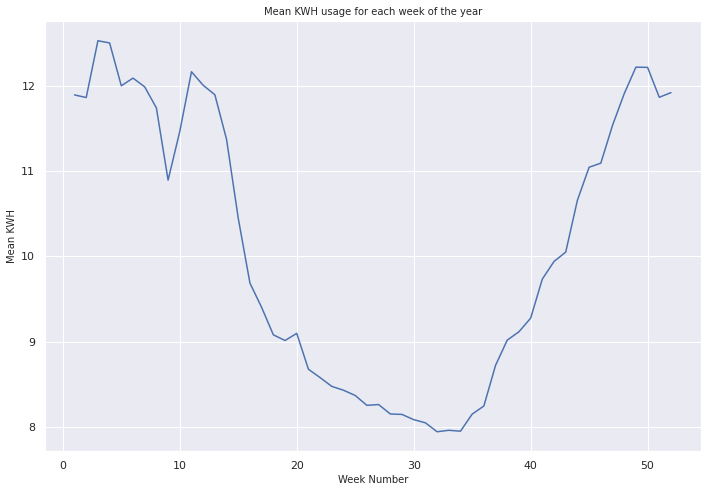

In [23]:
# sns.set(rc={'figure.figsize':(10, 7)})
fig, ax = plt.subplots(figsize=(10,7))
groupedByWeek = df.groupby("Week")['KWH'].mean() #get the series
sns.lineplot(data=groupedByWeek)
ax.set_title("Mean KWH usage for each week of the year", fontsize = 10)
ax.set_xlabel("Week Number", fontsize = 10)
ax.set_ylabel("Mean KWH", fontsize = 10)
fig.tight_layout(pad = 1.1)
plt.show()

Most usage seems to be in the winter when the temperature drops in london and there's high amount of heater usage.